# Imbalance evaluation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import os

import numpy as np
import pandas as pd
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import WeightedRandomSampler

from src.data.dataset import MovieDataset
from src.utils.const import DATA_DIR, SEED

### Useful path to data

In [3]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
PROCESSED_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'processed')

### Repeatability

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

## Import final dataset

In [5]:
df = pd.read_parquet(os.path.join(PROCESSED_DIR, 'final.parquet'))

## Work with Dataset

In [6]:
dataset = MovieDataset(df)

In [7]:
samples = np.arange(len(dataset))
train_idx_tmp, test_idx = train_test_split(samples, test_size=0.2, stratify=dataset.y)
train_idx, val_idx = train_test_split(train_idx_tmp, test_size=0.1, stratify=dataset.y[train_idx_tmp])

### WeightedRandomSampler

In [8]:
train_data = dataset.X[train_idx, :]
train_target = dataset.y[train_idx]
print(np.unique(train_target, return_counts=True))

counts = np.bincount(train_target)
labels_weights = 1. / counts
weights = torch.tensor(labels_weights[train_target], dtype=torch.float)
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([   5,   23,  102,  279,  707, 1508, 2542, 2898, 1348,   53],
      dtype=int64))
tensor([0.0007, 0.0003, 0.0004,  ..., 0.0003, 0.0007, 0.0003],
       dtype=torch.float64)


In [11]:
labels_weights = 1. / counts
labels_weights

array([0.2       , 0.04347826, 0.00980392, 0.00358423, 0.00141443,
       0.00066313, 0.00039339, 0.00034507, 0.00074184, 0.01886792])

In [13]:
labels_weights[train_target]

array([0.00066313, 0.00034507, 0.00039339, ..., 0.00034507, 0.00074184,
       0.00034507])

In [12]:
weights = torch.tensor(labels_weights[train_target], dtype=torch.float)
weights

tensor([0.0007, 0.0003, 0.0004,  ..., 0.0003, 0.0007, 0.0003])

### RandomOverSampler

In [33]:
train_data = dataset.X[train_idx, :]
train_target = dataset.y[train_idx]
print(np.unique(train_target, return_counts=True))

oversample = RandomOverSampler(sampling_strategy='auto')
train_data_over, train_target_over = oversample.fit_resample(train_data, train_target)
print(np.unique(train_target_over, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([   5,   23,  102,  279,  707, 1508, 2542, 2898, 1348,   53],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([2898, 2898, 2898, 2898, 2898, 2898, 2898, 2898, 2898, 2898],
      dtype=int64))


[Text(0.5, 0, 'Classes'),
 Text(0, 0.5, 'Number of samples'),
 Text(0.5, 1.0, 'Binning before oversampling')]

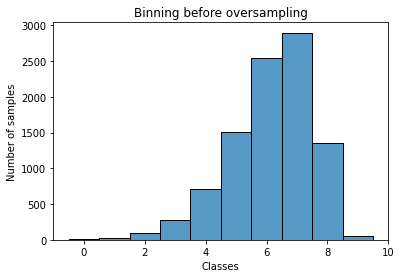

In [38]:
sns.histplot(
    data=train_target,
    discrete=True
).set(xlabel='Classes', ylabel='Number of samples', title='Binning before oversampling')

Text(0.5, 1.0, 'Binning after oversampling')

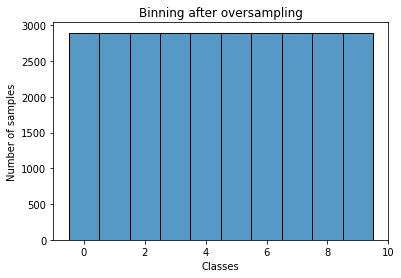

In [35]:
sns.histplot(
    data=train_target_over,
    discrete=True
).set(xlabel='Classes', ylabel='Number of samples')
plt.title('Binning after oversampling')